In [1]:
import os

os.environ['WANDB_API_KEY'] = ''


In [2]:
import os
import random
import time
from dataclasses import dataclass

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tyro
from torch.distributions.normal import Normal
from torch.utils.tensorboard import SummaryWriter


/home/user7/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment FetchSlide-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/user7/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment FetchSlide-v3 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/user7/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment FetchPickAndPlace-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/user7/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment FetchPickAndPlace-v3 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/user7/.venv/lib/python3.10/site-pack

In [3]:
import os
import random
import time
from dataclasses import dataclass

import gymnasium as gym
import gymnasium_robotics
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tyro
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


example_map = [[1, 1, 1, 1, 1],
        [1, 'c', 0, 0, 1],
        [1, 1, 1, 0, 1],
        [1, 'c', 0, 0, 1],
        [1, 1, 1, 1, 1]]

In [4]:
@dataclass
class Args:
    exp_name: str = os.path.basename(__file__)[: -len(".py")] if "__file__" in locals() else "ipynb_experiment"
    """the name of this experiment"""
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    track: bool = True
    """if toggled, this experiment will be tracked with Weights and Biases"""
    wandb_project_name: str = "AIRI_RL"
    """the wandb's project name"""
    wandb_entity: str = None
    """the entity (team) of wandb's project"""
    capture_video: bool = False
    """whether to capture videos of the agent performances (check out `videos` folder)"""
    save_model: bool = True
    """whether to save model into the `runs/{run_name}` folder"""
    upload_model: bool = False
    """whether to upload the saved model to huggingface"""
    hf_entity: str = ""
    """the user or org name of the model repository from the Hugging Face Hub"""

    # Algorithm specific arguments
    env_id: str = 'PointMaze_UMaze-v3'
    """the id of the environment"""
    total_timesteps: int = 100000
    """total timesteps of the experiments"""
    learning_rate: float = 3e-4
    """the learning rate of the optimizer"""
    num_envs: int = 1
    """the number of parallel game environments"""
    num_steps: int = 2048
    """the number of steps to run in each environment per policy rollout"""
    anneal_lr: bool = True
    """Toggle learning rate annealing for policy and value networks"""
    gamma: float = 0.99
    """the discount factor gamma"""
    gae_lambda: float = 0.95
    """the lambda for the general advantage estimation"""
    num_minibatches: int = 32
    """the number of mini-batches"""
    update_epochs: int = 10
    """the K epochs to update the policy"""
    norm_adv: bool = True
    """Toggles advantages normalization"""
    clip_coef: float = 0.2
    """the surrogate clipping coefficient"""
    clip_vloss: bool = True
    """Toggles whether or not to use a clipped loss for the value function, as per the paper."""
    ent_coef: float = 0.0
    """coefficient of the entropy"""
    vf_coef: float = 0.5
    """coefficient of the value function"""
    max_grad_norm: float = 0.5
    """the maximum norm for the gradient clipping"""
    target_kl: float = None
    """the target KL divergence threshold"""

    # to be filled in runtime
    batch_size: int = 0
    """the batch size (computed in runtime)"""
    minibatch_size: int = 0
    """the mini-batch size (computed in runtime)"""
    num_iterations: int = 0
    """the number of iterations (computed in runtime)"""

In [5]:
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation

def make_env(env_id, idx, capture_video, run_name, gamma):
    def thunk():
        # Set render_mode to 'rgb_array' if capturing video
        render_mode = "rgb_array" if capture_video and idx == 0 else None
        env = gym.make(env_id, render_mode=render_mode)
        env = FlattenObservation(env)
        if capture_video and idx == 0:
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        env = gym.wrappers.RecordEpisodeStatistics(env)
        return env
    return thunk


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

In [6]:
class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()

        input_dim  = int(np.prod(envs.single_observation_space.shape))
        action_dim = int(np.prod(envs.single_action_space.shape))

        self.critic = nn.Sequential(
            layer_init(nn.Linear(input_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(input_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, action_dim), std=0.01),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, action_dim))


    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.critic(x)

In [7]:
args = Args()
args.batch_size = int(args.num_envs * args.num_steps)
args.minibatch_size = int(args.batch_size // args.num_minibatches)
args.num_iterations = args.total_timesteps // args.batch_size
run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
if args.track:
    import wandb

    wandb.init(
        project=args.wandb_project_name,
        entity=args.wandb_entity,
        sync_tensorboard=True,
        config=vars(args),
        name=run_name,
        monitor_gym=True,
        save_code=True,
    )
writer = SummaryWriter(f"runs/{run_name}")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
)

wandb: Currently logged in as: gamershmidt-sofya (gamershmidt-sofya-innopolis-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
/home/user7/.venv/lib/python3.10/site-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/home/user7/.venv/lib/python3.10/site-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


In [8]:
# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

In [9]:
envs = gym.vector.SyncVectorEnv(
        [make_env(args.env_id, args.seed + i, i, args.capture_video, run_name) for i in range(args.num_envs)]
    )
assert isinstance(envs.single_action_space, gym.spaces.Box), "only continuous action space is supported"

In [10]:
agent = Agent(envs).to(device)
optimizer = optim.Adam(agent.parameters(), lr=args.learning_rate, eps=1e-5)

# ALGO Logic: Storage setup
obs = torch.zeros((args.num_steps, args.num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((args.num_steps, args.num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((args.num_steps, args.num_envs)).to(device)
rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
dones = torch.zeros((args.num_steps, args.num_envs)).to(device)
values = torch.zeros((args.num_steps, args.num_envs)).to(device)

# TRY NOT TO MODIFY: start the game
global_step = 0
start_time = time.time()
next_obs, _ = envs.reset(seed=args.seed)
next_obs = torch.Tensor(next_obs).to(device)
next_done = torch.zeros(args.num_envs).to(device)

In [12]:
# Train
for iteration in range(1, args.num_iterations + 1):
    # Annealing the rate if instructed to do so.
    if args.anneal_lr:
        frac = 1.0 - (iteration - 1.0) / args.num_iterations
        lrnow = frac * args.learning_rate
        optimizer.param_groups[0]["lr"] = lrnow

    for step in range(0, args.num_steps):
        global_step += args.num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, reward, terminations, truncations, infos = envs.step(action.cpu().numpy())
        next_done = np.logical_or(terminations, truncations)
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(next_done).to(device)

        if "final_info" in infos:
            for info in infos["final_info"]:
                if info and "episode" in info:
                    print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                    writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                    writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)

    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(args.num_steps)):
            if t == args.num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + args.gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + args.gamma * args.gae_lambda * nextnonterminal * lastgaelam
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(args.batch_size)
    clipfracs = []
    for epoch in range(args.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, args.batch_size, args.minibatch_size):
            end = start + args.minibatch_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > args.clip_coef).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if args.norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - args.clip_coef, 1 + args.clip_coef)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if args.clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -args.clip_coef,
                    args.clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - args.ent_coef * entropy_loss + v_loss * args.vf_coef

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), args.max_grad_norm)
            optimizer.step()

        if args.target_kl is not None and approx_kl > args.target_kl:
            break

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    # TRY NOT TO MODIFY: record rewards for plotting purposes
    writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
    writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
    writer.add_scalar("losses/explained_variance", explained_var, global_step)
    print("SPS:", int(global_step / (time.time() - start_time)))
    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)



KeyboardInterrupt: 

In [13]:

# Load the saved model
model_path = f"runs/PointMaze_UMaze-v3__ipynb_experiment__1__1751998495/ipynb_experiment.cleanrl_model"
agent = Agent(envs).to(device)
agent.load_state_dict(torch.load(model_path, map_location=device))
agent.eval()

# Evaluation parameters
num_eval_episodes = 100
success_count = 0

# Create evaluation environment
eval_env = gym.vector.SyncVectorEnv(
    [make_env(args.env_id, args.seed + i, True, "tmp", 1) for i in range(args.num_envs)]
)

# Run evaluation episodes
for _ in range(num_eval_episodes):
    obs, _ = eval_env.reset()
    terminated = [False]
    truncated = [False]
    for i in range(150):
        obs_tensor = torch.Tensor(obs).to(device)
        print(obs_tensor)
        with torch.no_grad():
            action, _, _, _ = agent.get_action_and_value(obs_tensor)
        obs, _, terminated, truncated, info = eval_env.step(action.cpu().numpy())
        if info['success']:
            success_count += 1
            break

# Calculate success rate
success_rate = success_count / num_eval_episodes
print(f"Success rate over {num_eval_episodes} episodes: {success_rate:.2%}")
eval_env.close()

tensor([[-1.1967,  0.9471,  1.1926,  0.0381, -1.1967,  0.9471,  0.0000,  0.0000]],
       device='cuda:0')
tensor([[-1.1943,  0.9447,  1.1926,  0.0381, -1.1943,  0.9447,  0.2382, -0.2382]],
       device='cuda:0')
tensor([[-1.1896,  0.9399,  1.1926,  0.0381, -1.1896,  0.9399,  0.4758, -0.4758]],
       device='cuda:0')
tensor([[-1.1825,  0.9328,  1.1926,  0.0381, -1.1825,  0.9328,  0.7128, -0.7128]],
       device='cuda:0')
tensor([[-1.1730,  0.9233,  1.1926,  0.0381, -1.1730,  0.9233,  0.9493, -0.9493]],
       device='cuda:0')
tensor([[-1.1611,  0.9115,  1.1926,  0.0381, -1.1611,  0.9115,  1.1852, -1.1852]],
       device='cuda:0')
tensor([[-1.1469,  0.8984,  1.1926,  0.0381, -1.1469,  0.8984,  1.4205, -1.3116]],
       device='cuda:0')
tensor([[-1.1303,  0.8829,  1.1926,  0.0381, -1.1303,  0.8829,  1.6553, -1.5467]],
       device='cuda:0')
tensor([[-1.1115,  0.8651,  1.1926,  0.0381, -1.1115,  0.8651,  1.8895, -1.7811]],
       device='cuda:0')
tensor([[-1.0902,  0.8449,  1.1926,  

KeyboardInterrupt: 

In [14]:
import os, ctypes.util

def configure_gl_backend():
    if os.getenv("MUJOCO_GL"):
        return                      # user already chose
    if ctypes.util.find_library("EGL"):
        os.environ["MUJOCO_GL"] = "egl"
        os.environ["PYOPENGL_PLATFORM"] = "egl"
    else:
        os.environ["MUJOCO_GL"] = "osmesa"
        os.environ["PYOPENGL_PLATFORM"] = "osmesa"

configure_gl_backend()

import gymnasium as gym
import torch

env = gym.make(args.env_id, render_mode="rgb_array")
env = FlattenObservation(env)
env = gym.wrappers.RecordVideo(env,video_folder="videos/stage1")
env = gym.wrappers.RecordEpisodeStatistics(env)
obs, _ = env.reset()
for i in range(150):
        obs_tensor = torch.Tensor(obs).to(device)
        obs_tensor = obs_tensor.reshape(1,-1)
        with torch.no_grad():
            action, _, _, _ = agent.get_action_and_value(obs_tensor)
        obs, _, terminated, truncated, info = eval_env.step(action.cpu().numpy())
        # print(obs.shape)
        if info['success']:
            success_count += 1
            break
env.close()


/home/user7/.venv/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /home/user7/07-distance-to-goal-learning/PPO_Clean_RL_PointMaze/videos/stage1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/user7/07-distance-to-goal-learning/PPO_Clean_RL_PointMaze/videos/stage1/rl-video-episode-0.mp4.
Moviepy - Writing video /home/user7/07-distance-to-goal-learning/PPO_Clean_RL_PointMaze/videos/stage1/rl-video-episode-0.mp4



wandb: WARNING `format` argument was not provided, defaulting to `gif`. This parameter will be required in v0.20.0, please specify the format explicitly.


Moviepy - Done !
Moviepy - video ready /home/user7/07-distance-to-goal-learning/PPO_Clean_RL_PointMaze/videos/stage1/rl-video-episode-0.mp4


/home/user7/.venv/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /home/user7/07-distance-to-goal-learning/PPO_Clean_RL_PointMaze/videos/stage1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


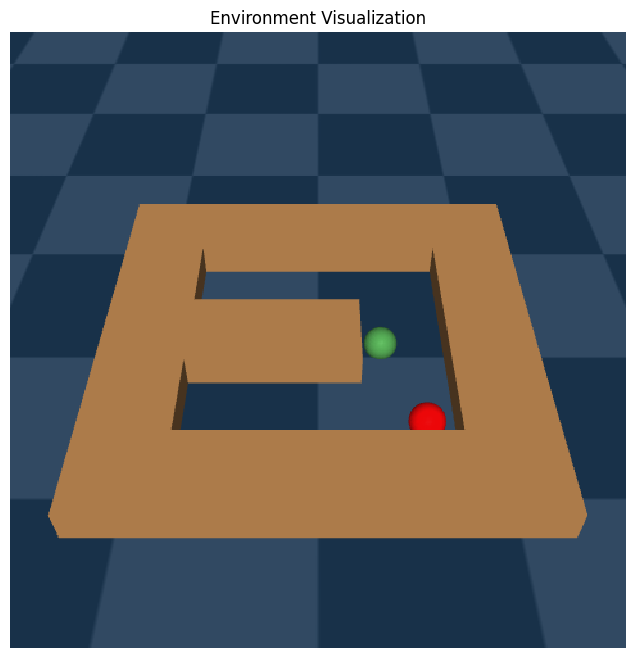

Moviepy - Building video /home/user7/07-distance-to-goal-learning/PPO_Clean_RL_PointMaze/videos/stage1/rl-video-episode-0.mp4.
Moviepy - Writing video /home/user7/07-distance-to-goal-learning/PPO_Clean_RL_PointMaze/videos/stage1/rl-video-episode-0.mp4



wandb: WARNING `format` argument was not provided, defaulting to `gif`. This parameter will be required in v0.20.0, please specify the format explicitly.


Moviepy - Done !
Moviepy - video ready /home/user7/07-distance-to-goal-learning/PPO_Clean_RL_PointMaze/videos/stage1/rl-video-episode-0.mp4


MovieWriter ffmpeg unavailable; using Pillow instead.


In [17]:
import os
import ctypes.util
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

def configure_gl_backend():
    if os.getenv("MUJOCO_GL"):
        return                      # user already chose
    if ctypes.util.find_library("EGL"):
        os.environ["MUJOCO_GL"] = "egl"
        os.environ["PYOPENGL_PLATFORM"] = "egl"
    else:
        os.environ["MUJOCO_GL"] = "osmesa"
        os.environ["PYOPENGL_PLATFORM"] = "osmesa"

configure_gl_backend()

import gymnasium as gym
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make(args.env_id, render_mode="rgb_array")
env = gym.wrappers.FlattenObservation(env)
env = gym.wrappers.RecordVideo(env, video_folder="videos/stage1")
env = gym.wrappers.RecordEpisodeStatistics(env)

# Initialize matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))
img_display = ax.imshow(np.zeros((100, 100, 3)), interpolation='nearest')
ax.axis('off')
plt.title('Environment Visualization')

# Store frames for animation
frames = []

obs, _ = env.reset()
success_count = 0

for i in range(150):
    # Get frame from environment
    frame = env.render()
    frames.append(frame)
    
    # Update display
    img_display.set_array(frame)
    plt.pause(0.01)  # Small pause to allow the display to update
    
    obs_tensor = torch.Tensor(obs).to(device)
    obs_tensor = obs_tensor.reshape(1, -1)
    
    with torch.no_grad():
        action, _, _, _ = agent.get_action_and_value(obs_tensor)  # Assuming agent is defined
    
    # Remove the batch dimension before passing to environment
    action = action.squeeze(0).cpu().numpy()
    
    obs, _, terminated, truncated, info = env.step(action)
    # print(obs.shape)
    
    if 'success' in info and info['success']:
        success_count += 1
        break

env.close()

# Create an animation from the collected frames
def update_frame(i):
    img_display.set_array(frames[i])
    return img_display,

ani = FuncAnimation(fig, update_frame, frames=len(frames), interval=50, blit=True)

# To save the animation:
ani.save('videos/environment_animation.gif', writer='ffmpeg', fps=30)

plt.show()

In [19]:
import os
import ctypes.util
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

def configure_gl_backend():
    if os.getenv("MUJOCO_GL"):
        return
    if ctypes.util.find_library("EGL"):
        os.environ["MUJOCO_GL"] = "egl"
        os.environ["PYOPENGL_PLATFORM"] = "egl"
    else:
        os.environ["MUJOCO_GL"] = "osmesa"
        os.environ["PYOPENGL_PLATFORM"] = "osmesa"

configure_gl_backend()

import gymnasium as gym
import torch

# Configuration
num_trials =10 # Number of trials to run
max_steps_per_trial = 200

# Create environment
env = gym.make(args.env_id, render_mode="rgb_array")
env = gym.wrappers.FlattenObservation(env)
env = gym.wrappers.RecordVideo(env, video_folder="videos/stage1")
env = gym.wrappers.RecordEpisodeStatistics(env)

def run_trial(trial_num):
    """Run a single trial and return frames and success status"""
    obs, _ = env.reset()
    frames = []
    success = False
    
    for i in range(max_steps_per_trial):
        frame = env.render()
        frames.append(frame)
        
        obs_tensor = torch.Tensor(obs).to(device).reshape(1, -1)
        
        with torch.no_grad():
            action, _, _, _ = agent.get_action_and_value(obs_tensor)
        
        action = action.squeeze(0).cpu().numpy()
        obs, _, terminated, truncated, info = env.step(action)
        
        if 'success' in info and info['success']:
            success = True
            break
            
    return frames, success

def create_animation(frames, trial_num, success):
    """Create and save animation for a single trial"""
    fig, ax = plt.subplots(figsize=(10, 8))
    img = ax.imshow(frames[0], interpolation='nearest')
    ax.axis('off')
    plt.title(f'Trial {trial_num} - {"Success" if success else "Failed"}')
    
    def update(frame):
        img.set_array(frame)
        return img,
    
    ani = FuncAnimation(fig, update, frames=frames, interval=50, blit=True)
    
    # Save the animation
    ani.save(f'trial_{trial_num}.gif', writer='ffmpeg', fps=30)
    plt.close(fig)

# Run multiple trials
success_count = 0
for trial in range(num_trials):
    print(f"Running trial {trial+1}/{num_trials}")
    frames, success = run_trial(trial+1)
    if success:
        success_count += 1
    create_animation(frames, trial+1, success)

env.close()

# Print summary
print(f"\nTrials completed: {num_trials}")
print(f"Success rate: {success_count/num_trials:.2%}")

Moviepy - Building video /home/user7/07-distance-to-goal-learning/PPO_Clean_RL_PointMaze/videos/stage1/rl-video-episode-0.mp4.
Moviepy - Writing video /home/user7/07-distance-to-goal-learning/PPO_Clean_RL_PointMaze/videos/stage1/rl-video-episode-0.mp4



/home/user7/.venv/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /home/user7/07-distance-to-goal-learning/PPO_Clean_RL_PointMaze/videos/stage1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Done !
Moviepy - video ready /home/user7/07-distance-to-goal-learning/PPO_Clean_RL_PointMaze/videos/stage1/rl-video-episode-0.mp4
Running trial 1/10


MovieWriter ffmpeg unavailable; using Pillow instead.


Running trial 2/10


MovieWriter ffmpeg unavailable; using Pillow instead.


Running trial 3/10


MovieWriter ffmpeg unavailable; using Pillow instead.


Running trial 4/10


MovieWriter ffmpeg unavailable; using Pillow instead.


Running trial 5/10


MovieWriter ffmpeg unavailable; using Pillow instead.


Running trial 6/10


MovieWriter ffmpeg unavailable; using Pillow instead.


Running trial 7/10


MovieWriter ffmpeg unavailable; using Pillow instead.


Running trial 8/10


MovieWriter ffmpeg unavailable; using Pillow instead.


Running trial 9/10


MovieWriter ffmpeg unavailable; using Pillow instead.


Running trial 10/10


MovieWriter ffmpeg unavailable; using Pillow instead.


Moviepy - Building video /home/user7/07-distance-to-goal-learning/PPO_Clean_RL_PointMaze/videos/stage1/rl-video-episode-0.mp4.
Moviepy - Writing video /home/user7/07-distance-to-goal-learning/PPO_Clean_RL_PointMaze/videos/stage1/rl-video-episode-0.mp4



wandb: WARNING `format` argument was not provided, defaulting to `gif`. This parameter will be required in v0.20.0, please specify the format explicitly.


Moviepy - Done !
Moviepy - video ready /home/user7/07-distance-to-goal-learning/PPO_Clean_RL_PointMaze/videos/stage1/rl-video-episode-0.mp4

Trials completed: 10
Success rate: 90.00%
